In [50]:
# load package
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import scipy
import math
import geopandas as gp
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [208]:
# 评价指标
def evaluation(real_y, prediction_y):

    # rmse  mae  r2  r
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real_y, prediction_y)
    print("R-squared", r_value**2)
    print("R", r_value)

    mae = mean_absolute_error(real_y, prediction_y)
    print("mae", mae)

    rmse = mean_squared_error(real_y, prediction_y) ** 0.5
    print("rmse", rmse)

    ############# 设置图例并且设置图例的字体及大小 #############
    font1 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 15,
            }
    
    figsize = 20,16
    figure, ax = plt.subplots(figsize=figsize)
    level = [50000, 5500, 1000, 200, 100, 80, 60, 40,20]
    for i in range(len(level)):

        plt.subplot(3,3,i+1)
        plt.scatter(real_y, prediction_y, c='b', marker='o', label='', s=10, alpha=0.7, zorder=20)
        plt.plot([0, 50000], [0, 50000], '--', color='black', label='', linewidth=1.0)
        
        ############# 设置坐标刻度值的大小以及刻度值的字体 #############
        plt.xlim(0, level[i])
        plt.ylim(0, level[i])
        plt.tick_params(labelsize=15)
        
        plt.ylabel('prediction', font1)
        plt.xlabel('real', font1)

        # x，y轴设置显示刻度一致
        ax = plt.gca()
        ax.set_aspect(1)
    
    plt.show()


# 疫情建模
def covid_all_predict(df, index, threshold):

    '''
    df = df[['id','location',
    'rhMean','rhMax','rhMin',
    't2mMean','t2mMax','t2mMin',
    'moveInMean','moveInMax','moveInMin',
    'moveOutMea','moveOutMax','moveOutMin',
    'travelMean','travelMax','travelMin',
    'WuhanMean','WuhanMax','WuhanMin',
    'confirmed','confirmLog','npp']]
    '''
    
    df = df[['id','location',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
    'confirmed','confirmLog', 'X', 'Y']]

    real_y = []
    prediction_y = []

    df_predict = []

    case = []

    for i in range(len(index)):

        train_df = df.iloc[index[i][0], :]
        test_df = df.iloc[index[i][1], :]

        df_predict.extend(test_df['id'].to_list())

        train_y_log = train_df['confirmLog'].values.reshape((-1,1))
        train_y = train_df['confirmed'].values.reshape((-1,1)).flatten()
        u = train_df['X']
        v = train_df['Y']
        cal_coords = list(zip(u,v))

        train_x = train_df.drop(['id', 'location', 'confirmLog', 'confirmed', 'X', 'Y'], axis=1).values

        test_y = test_df['confirmed'].values.reshape((-1,1)).flatten()
        test_x = test_df.drop(['id', 'location', 'confirmLog', 'confirmed', 'X', 'Y'], axis=1).values
        
        u = test_df['X']
        v = test_df['Y']
        pred_coords = list(zip(u,v))
        
        #Calibrate GWR model
        gwr_selector = Sel_BW(np.array(cal_coords), train_y_log, train_x)
        gwr_bw = gwr_selector.search(criterion = 'AICc')
        #gwr_bw = gwr_selector.search(bw_min=20)
        print(gwr_bw)
        model = GWR(np.array(cal_coords), train_y_log, train_x, gwr_bw)
        gwr_results = model.fit()

        scale = gwr_results.scale
        residuals = gwr_results.resid_response

        predict_ytrain_log = model.predict(np.array(cal_coords), train_x, scale, residuals).predictions.flatten()
        predict_ytrain = np.trunc(np.exp(predict_ytrain_log) - 1)

        predict_ytest_log = model.predict(np.array(pred_coords), test_x, scale, residuals).predictions.flatten()
        predict_ytest = np.trunc(np.exp(predict_ytest_log) - 1)
        
        
        real_y.extend(test_y)
        prediction_y.extend(predict_ytest)

        print("train fold " + str(i+1))
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        predict_train_y = list(predict_ytrain)
        train_yy = list(train_y)
        for j in range(len(train_df)):
            if abs(train_yy[j]-predict_train_y[j])>threshold:
                print(train_df.iloc[j, 1] + "   real: " + str(train_yy[j]) + "   pre:" + str(predict_train_y[j]))
                #case.append(train_df.iloc[j, 0])

        evaluation(train_yy, predict_train_y)


        print("#########################################")
        print("test fold " + str(i+1))
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        predict_test_y = list(predict_ytest)
        test_yy = list(test_y)
        for j in range(len(test_df)):
            if abs(test_yy[j]-predict_test_y[j])>threshold:
                print(test_df.iloc[j, 1] + "   real: " + str(test_yy[j]) + "   pre:" + str(predict_test_y[j]))
                case.append(test_df.iloc[j, 0])

        evaluation(test_yy, predict_test_y)
    

    df_predict = pd.DataFrame(df_predict)
    df_predict.columns = ['id']
    df_predict['predict'] = prediction_y

    print("************* cv evaluation ***************")
    evaluation(real_y, prediction_y)

    return case, df_predict

In [52]:
# 所有城市全时间段建模

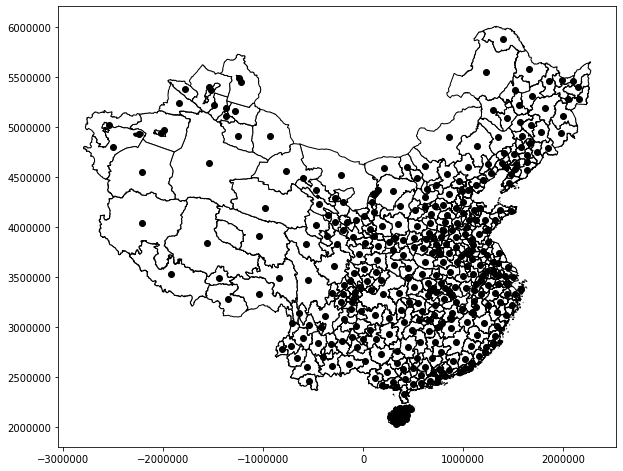

In [53]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19.shp")

fig, ax = plt.subplots(figsize=(10,10))
df.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
df.centroid.plot(ax=ax, c='black')

77.0
train fold 1
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 580   pre:744.0
天津市   real: 174   pre:75.0
哈尔滨市   real: 198   pre:136.0
南京市   real: 93   pre:183.0
杭州市   real: 181   pre:272.0
宁波市   real: 157   pre:50.0
温州市   real: 504   pre:197.0
金华市   real: 55   pre:135.0
台州市   real: 146   pre:53.0
丽水市   real: 17   pre:71.0
合肥市   real: 174   pre:235.0
蚌埠市   real: 160   pre:47.0
阜阳市   real: 155   pre:45.0
南昌市   real: 230   pre:157.0
宜春市   real: 106   pre:52.0
抚州市   real: 72   pre:17.0
商丘市   real: 91   pre:33.0
武汉市   real: 50006   pre:51788.0
十堰市   real: 672   pre:225.0
宜昌市   real: 931   pre:374.0
襄阳市   real: 1175   pre:482.0
荆州市   real: 1580   pre:1030.0
黄冈市   real: 2907   pre:3709.0
咸宁市   real: 836   pre:299.0
随州市   real: 1307   pre:447.0
恩施土家族苗族自治州   real: 252   pre:114.0
潜江市   real: 198   pre:448.0
天门市   real: 496   pre:213.0
长沙市   real: 242   pre:459.0
邵阳市   real: 102   pre:29.0
珠海市   real: 103   pre:27.0
东莞市   real: 100   pre:177.0
重庆市   real: 579   pre:1026.0
贵阳市   real: 36   pre:109.0
渭南市   

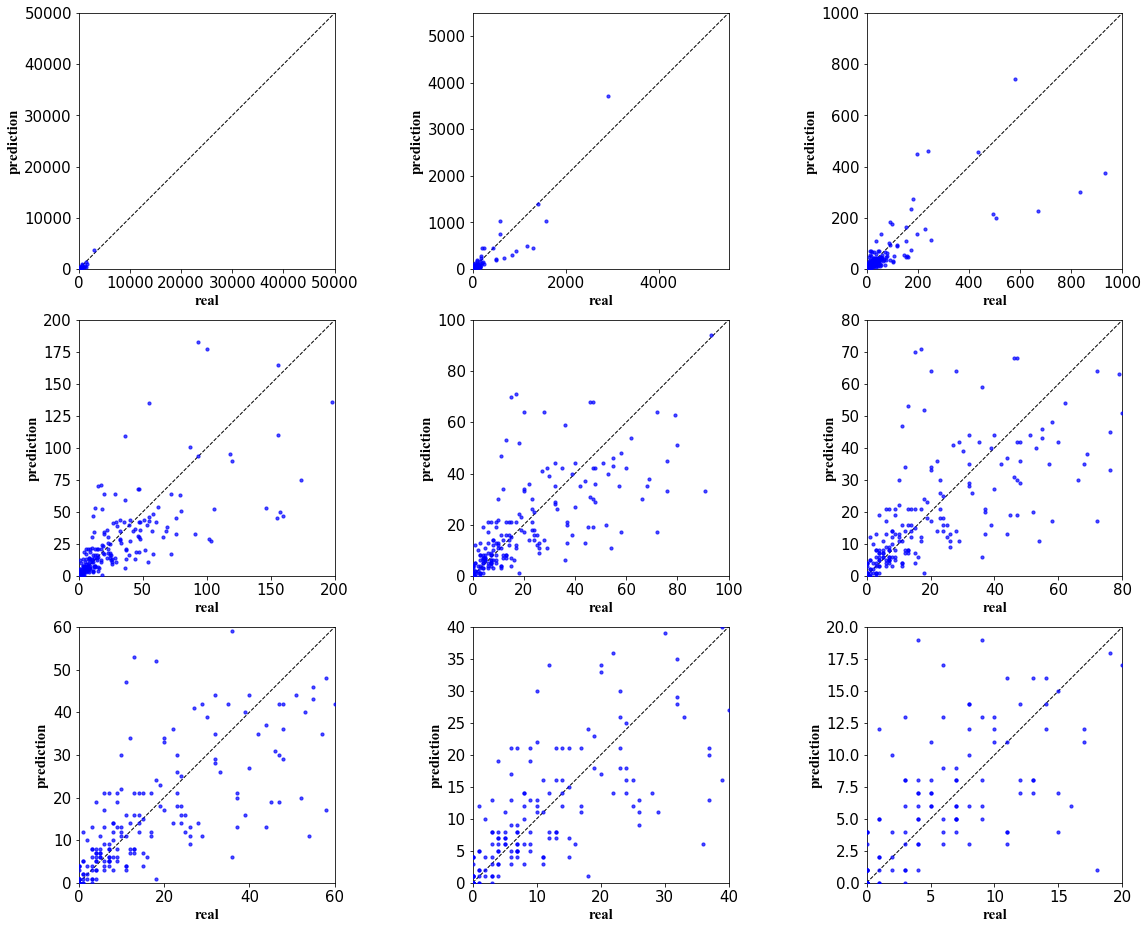

#########################################
test fold 1
预测误差较大城市，绝对值误差阈值设置为50
上海市   real: 516   pre:228.0
湖州市   real: 10   pre:61.0
安庆市   real: 83   pre:25.0
亳州市   real: 108   pre:10.0
新余市   real: 130   pre:46.0
上饶市   real: 123   pre:35.0
济宁市   real: 260   pre:41.0
郑州市   real: 157   pre:943.0
驻马店市   real: 139   pre:85.0
黄石市   real: 1015   pre:404.0
荆门市   real: 928   pre:361.0
孝感市   real: 3518   pre:3656.0
深圳市   real: 450   pre:281.0
成都市   real: 155   pre:831.0
甘孜藏族自治州   real: 78   pre:1.0
昆明市   real: 53   pre:140.0
咸阳市   real: 17   pre:204.0
R-squared 0.8671136756825101
R 0.9311893876556531
mae 42.6198347107438
rmse 130.09764292336305


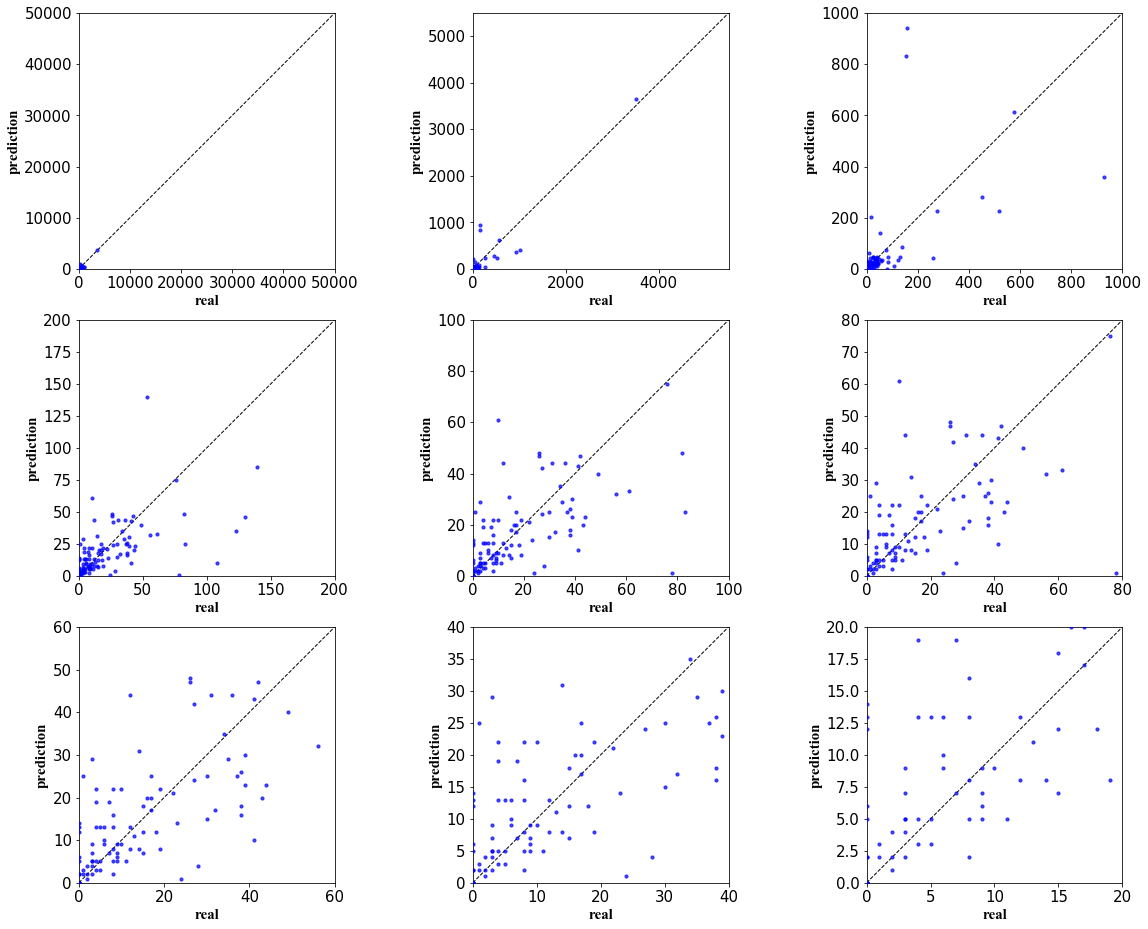

60.0
train fold 2
预测误差较大城市，绝对值误差阈值设置为50
上海市   real: 516   pre:414.0
南京市   real: 93   pre:157.0
苏州市   real: 87   pre:171.0
温州市   real: 504   pre:285.0
台州市   real: 146   pre:64.0
阜阳市   real: 155   pre:65.0
亳州市   real: 108   pre:26.0
新余市   real: 130   pre:63.0
抚州市   real: 72   pre:21.0
上饶市   real: 123   pre:47.0
济宁市   real: 260   pre:48.0
郑州市   real: 157   pre:247.0
信阳市   real: 274   pre:332.0
武汉市   real: 50006   pre:51923.0
黄石市   real: 1015   pre:553.0
宜昌市   real: 931   pre:644.0
襄阳市   real: 1175   pre:539.0
鄂州市   real: 1394   pre:1489.0
荆门市   real: 928   pre:401.0
孝感市   real: 3518   pre:5110.0
荆州市   real: 1580   pre:1284.0
咸宁市   real: 836   pre:420.0
随州市   real: 1307   pre:485.0
仙桃市   real: 575   pre:655.0
潜江市   real: 198   pre:424.0
邵阳市   real: 102   pre:35.0
深圳市   real: 450   pre:723.0
珠海市   real: 103   pre:23.0
甘孜藏族自治州   real: 78   pre:2.0
R-squared 0.9982759705205904
R 0.9991376134049755
mae 46.04979253112033
rmse 187.66474919730211


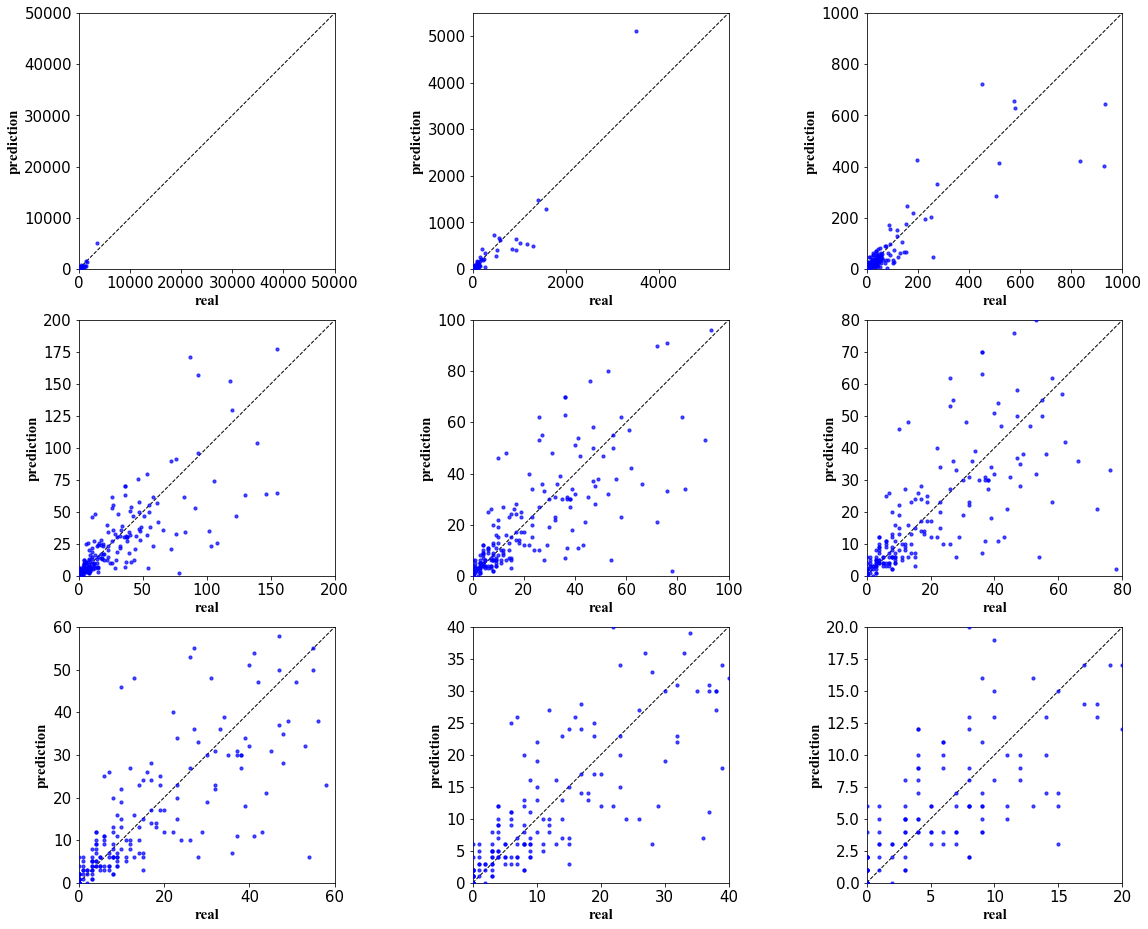

#########################################
test fold 2
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 174   pre:66.0
廊坊市   real: 30   pre:82.0
哈尔滨市   real: 198   pre:11.0
宁波市   real: 157   pre:65.0
金华市   real: 55   pre:160.0
丽水市   real: 17   pre:80.0
合肥市   real: 174   pre:250.0
蚌埠市   real: 160   pre:52.0
南平市   real: 20   pre:100.0
十堰市   real: 672   pre:269.0
黄冈市   real: 2907   pre:7761.0
天门市   real: 496   pre:227.0
神农架林区   real: 11   pre:103.0
长沙市   real: 242   pre:1233.0
广州市   real: 435   pre:1061.0
东莞市   real: 100   pre:214.0
重庆市   real: 579   pre:237.0
R-squared 0.9093943114513673
R 0.9536216815128352
mae 79.375
rmse 460.28499323788515


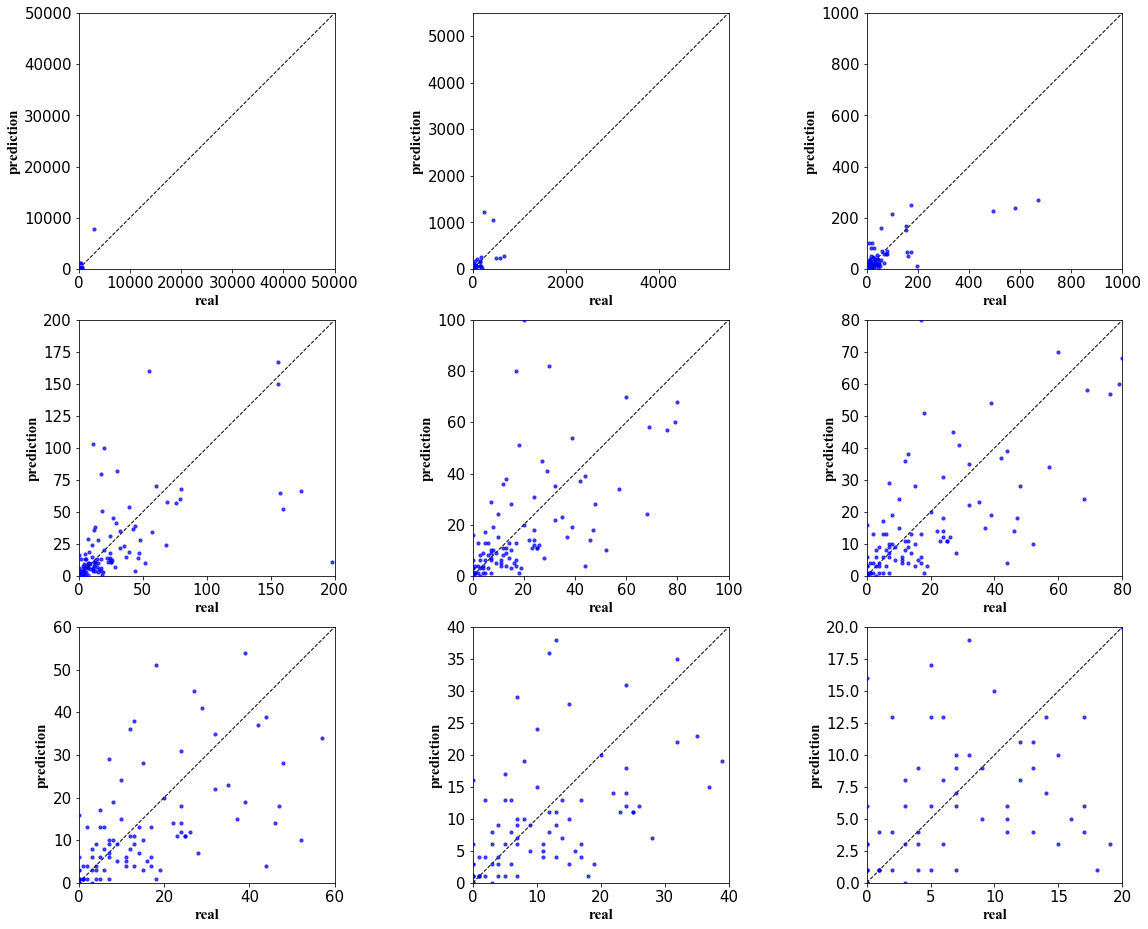

66.0
train fold 3
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 174   pre:69.0
上海市   real: 516   pre:577.0
宁波市   real: 157   pre:52.0
蚌埠市   real: 160   pre:45.0
安庆市   real: 83   pre:27.0
亳州市   real: 108   pre:21.0
新余市   real: 130   pre:59.0
上饶市   real: 123   pre:37.0
济宁市   real: 260   pre:42.0
郑州市   real: 157   pre:290.0
南阳市   real: 156   pre:97.0
信阳市   real: 274   pre:219.0
黄石市   real: 1015   pre:429.0
十堰市   real: 672   pre:162.0
荆门市   real: 928   pre:417.0
孝感市   real: 3518   pre:2861.0
黄冈市   real: 2907   pre:4739.0
仙桃市   real: 575   pre:741.0
天门市   real: 496   pre:285.0
岳阳市   real: 156   pre:99.0
深圳市   real: 450   pre:521.0
东莞市   real: 100   pre:158.0
重庆市   real: 579   pre:480.0
甘孜藏族自治州   real: 78   pre:1.0
R-squared 0.8494585019659681
R 0.9216607304024448
mae 32.6804979253112
rmse 142.97813430020273


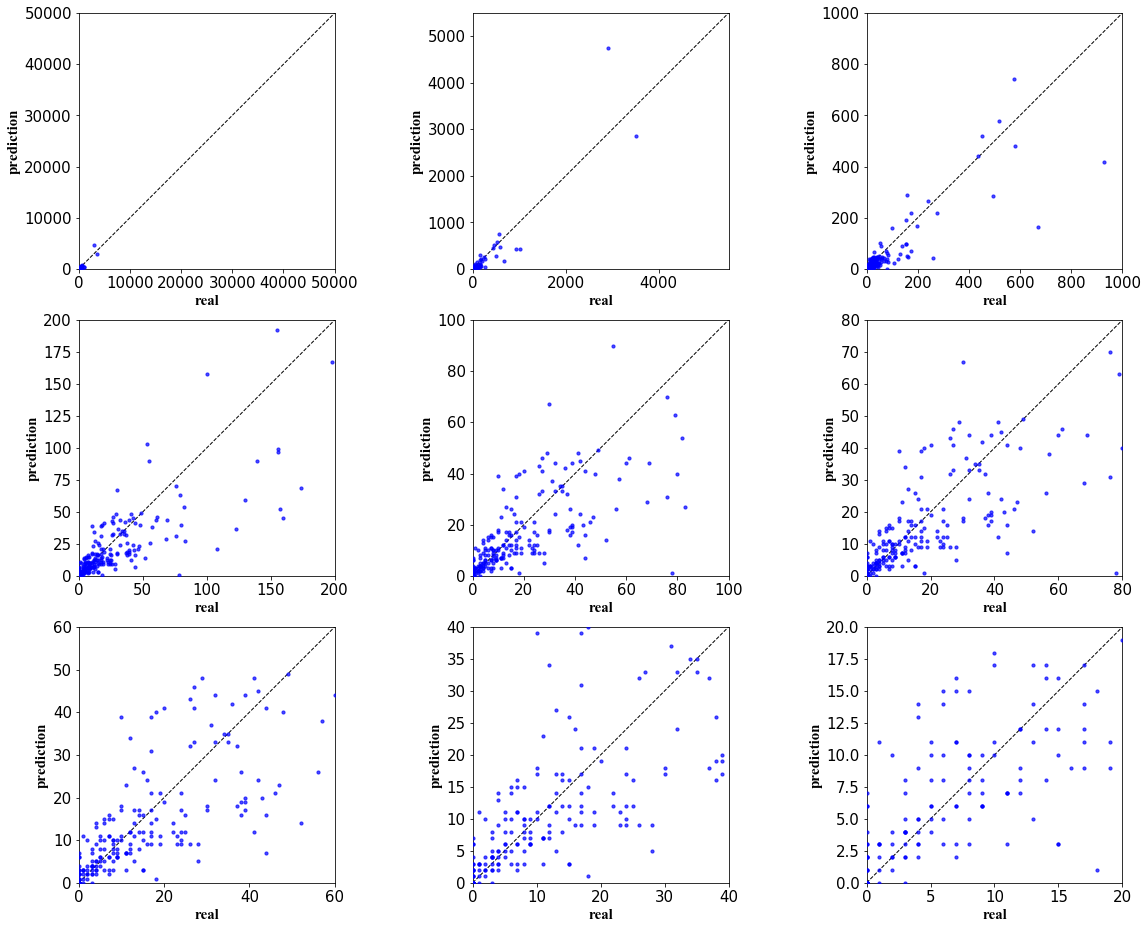

#########################################
test fold 3
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 580   pre:2018.0
沈阳市   real: 28   pre:102.0
南京市   real: 93   pre:217.0
苏州市   real: 87   pre:266.0
杭州市   real: 181   pre:295.0
温州市   real: 504   pre:98.0
台州市   real: 146   pre:40.0
阜阳市   real: 155   pre:57.0
南昌市   real: 230   pre:143.0
赣州市   real: 76   pre:15.0
宜春市   real: 106   pre:48.0
抚州市   real: 72   pre:17.0
商丘市   real: 91   pre:40.0
武汉市   real: 50006   pre:45768.0
宜昌市   real: 931   pre:235.0
襄阳市   real: 1175   pre:362.0
荆州市   real: 1580   pre:1065.0
咸宁市   real: 836   pre:350.0
随州市   real: 1307   pre:403.0
恩施土家族苗族自治州   real: 252   pre:113.0
潜江市   real: 198   pre:550.0
邵阳市   real: 102   pre:23.0
珠海市   real: 103   pre:21.0
R-squared 0.9978474317129581
R 0.9989231360384833
mae 101.28333333333333
rmse 437.2758663970987


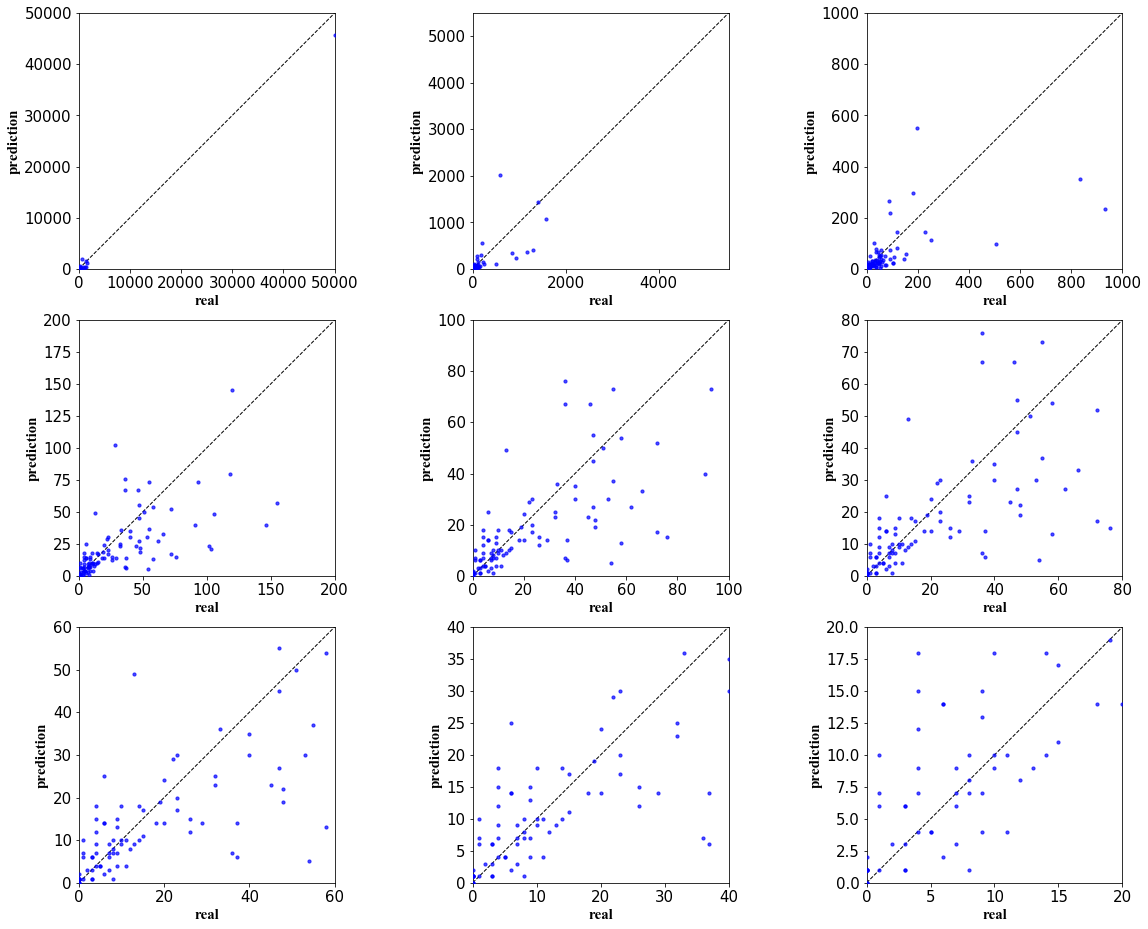

************* cv evaluation ***************
R-squared 0.9841748441433819
R 0.9920558674507106
mae 74.33795013850416
rmse 373.7089243124966


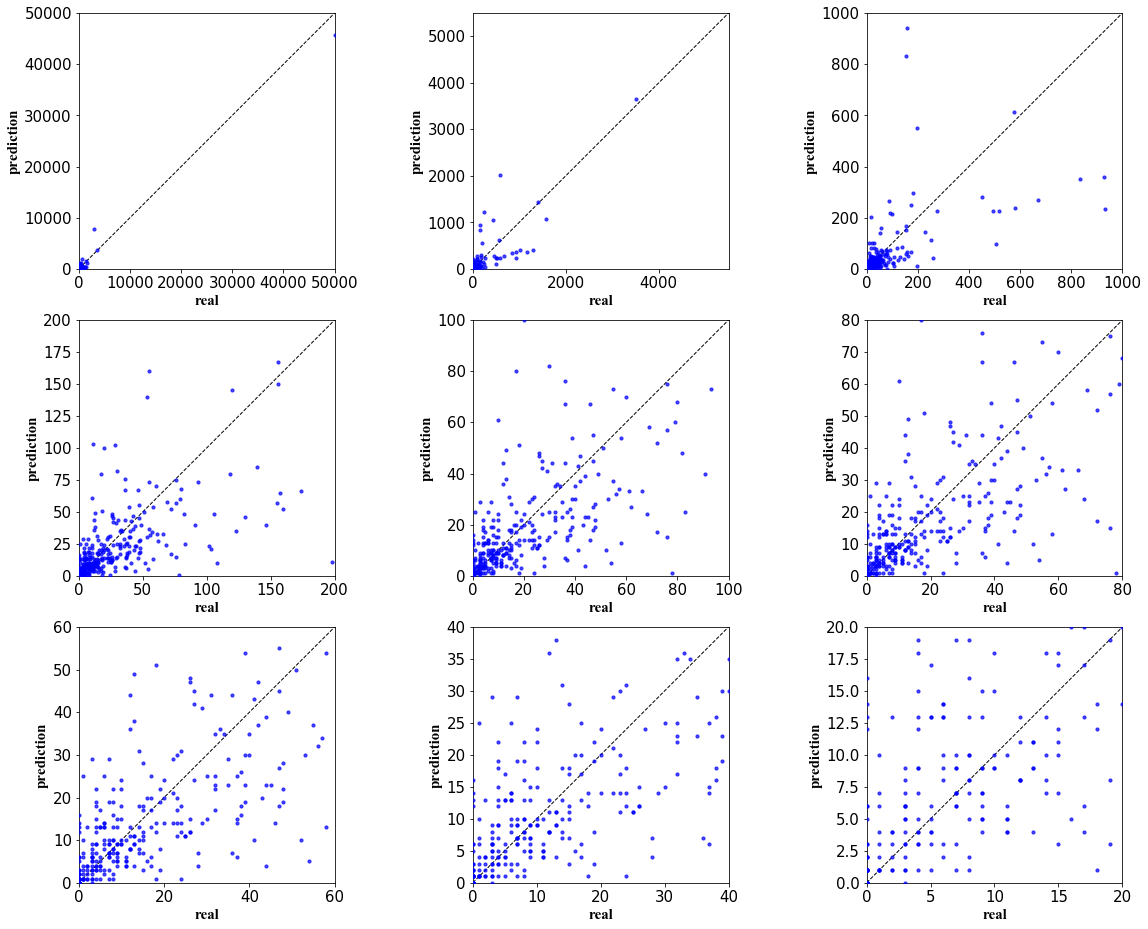

In [54]:
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id 疫情灾区id，暂定武汉
epidemicIds = [420100]

# 全时间段建模
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 50)

In [55]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [56]:
# 预测过低的城市

# 与随机森林预测过低的结果类似，不过我不知道怎么解释，实在不懂这个模型。。。

# 甘孜藏族自治州预测极低会是由于距离太远，而且没有直接的武汉迁入，gwr考虑空间，或许是这个原因？？？

In [57]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
167,420100,武汉市,50006,45768.0,71.607512,282.498292,1.441894,2.023355,1.722975,100.000000,4238.0
178,421300,随州市,1307,403.0,70.903198,281.069625,0.238099,0.192810,2.924918,2.167692,904.0
171,420600,襄阳市,1175,362.0,71.201756,280.692857,0.499872,0.428895,3.136352,3.597582,813.0
170,420500,宜昌市,931,235.0,76.941379,280.064152,0.421915,0.356423,3.151497,4.472088,696.0
168,420200,黄石市,1015,404.0,75.269348,282.796069,0.349638,0.311960,3.025581,3.193187,611.0
173,420800,荆门市,928,361.0,71.598185,281.899670,0.321647,0.279806,3.208329,2.742308,567.0
175,421000,荆州市,1580,1065.0,72.381365,282.634814,0.692491,0.586977,3.262016,6.604396,515.0
177,421200,咸宁市,836,350.0,76.139420,282.601893,0.329820,0.267432,3.433240,6.370220,486.0
88,330300,温州市,504,98.0,78.798802,284.332806,1.139140,1.407472,3.042697,0.088022,406.0
169,420300,十堰市,672,269.0,71.845056,279.256399,0.275357,0.244492,3.025281,3.124835,403.0


In [58]:
# 预测过高的城市
# 郑州和成都高的有些离谱
# 神农架林区和潜江本身不大，人口不多，会是因为跟武汉离得太近所以预测的偏高？？？

In [59]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
176,421100,黄冈市,2907,7761.0,73.669439,281.858747,0.785669,0.582993,3.386525,18.594066,-4854.0
0,110000,北京市,580,2018.0,46.602664,272.940185,4.460553,4.917454,3.281025,0.467143,-1438.0
184,430100,长沙市,242,1233.0,78.196887,283.294240,3.008522,3.068457,3.394593,0.728791,-991.0
149,410100,郑州市,157,943.0,58.902450,280.062032,3.181735,3.165202,3.335111,0.483516,-786.0
252,510100,成都市,155,831.0,75.993469,280.945180,4.778249,5.096423,3.602126,0.277692,-676.0
198,440100,广州市,435,1061.0,74.345041,290.998782,5.852615,6.362721,2.795382,0.400220,-626.0
181,429005,潜江市,198,550.0,71.633491,282.448468,0.142624,0.125334,2.839349,1.044615,-352.0
308,610400,咸阳市,17,204.0,56.298656,277.463500,1.486048,1.364976,3.261233,0.012967,-187.0
77,320500,苏州市,87,266.0,72.714776,282.295452,3.541147,3.844228,4.246995,0.177363,-179.0
174,420900,孝感市,3518,3656.0,71.152424,281.712290,0.581259,0.472132,2.987432,15.480989,-138.0


In [11]:
# GWR训练很不稳定，cv-R2倒是很高，一直很高，都是0.9以上

# cv预测结果非常不稳定，武汉有的时候预测高的达到e10左右，其他地区（湖北等地）都上万

# 我调了很久，挑了个还算不那么离谱的结果，不过也存在很多不合理的地方，预测过高的地方很多跟武汉都没有直接联系，距离上离得也没那么近

In [ ]:
# 管控前各个城市疫情预测

91.0
train fold 1
预测误差较大城市，绝对值误差阈值设置为20
温州市   real: 32   pre:4.0
武汉市   real: 698   pre:1628.0
十堰市   real: 40   pre:3.0
宜昌市   real: 31   pre:4.0
荆门市   real: 90   pre:3.0
孝感市   real: 100   pre:10.0
荆州市   real: 47   pre:7.0
咸宁市   real: 64   pre:5.0
随州市   real: 52   pre:3.0
恩施土家族苗族自治州   real: 25   pre:4.0
重庆市   real: 110   pre:73.0
R-squared 0.9290098788520562
R 0.9638515854902435
mae 7.820833333333334
rmse 61.101384326925576


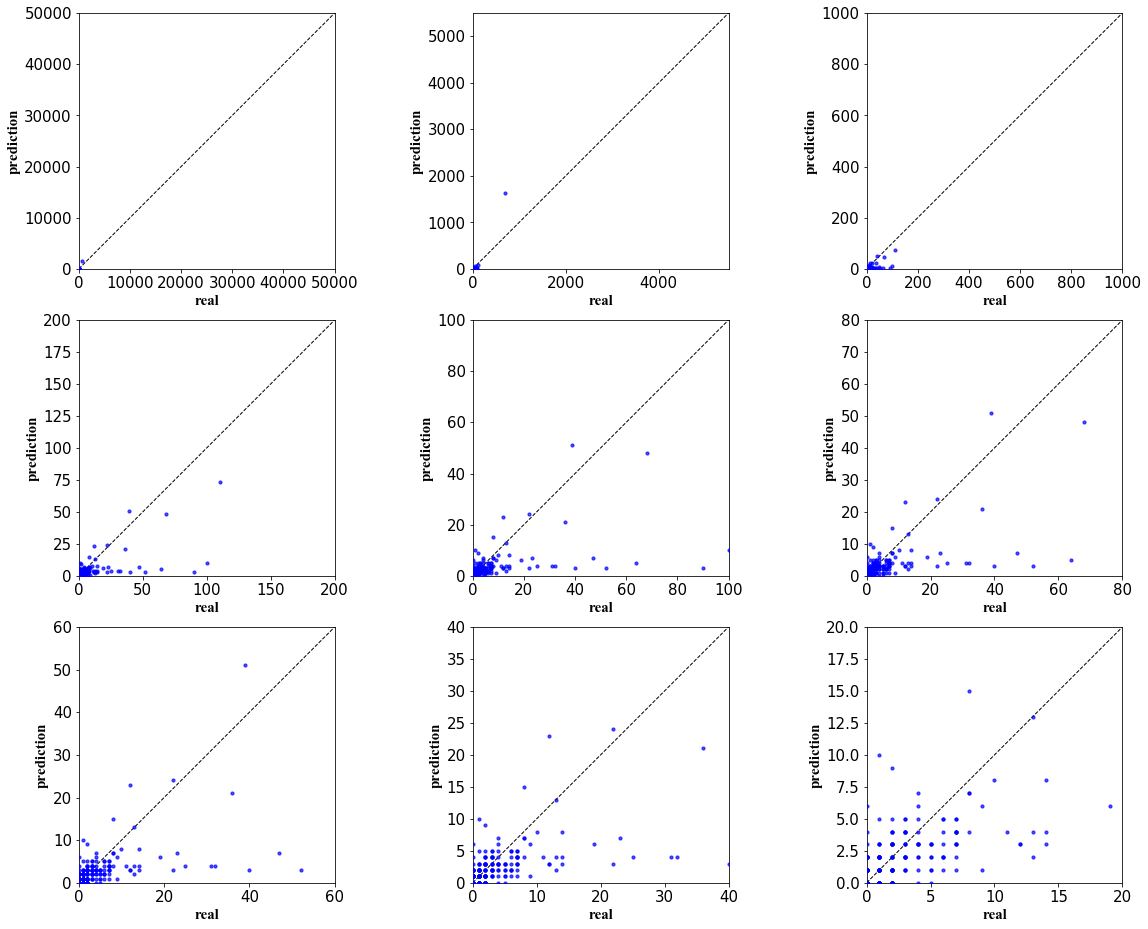

#########################################
test fold 1
预测误差较大城市，绝对值误差阈值设置为20
黄石市   real: 36   pre:4.0
襄阳市   real: 36   pre:4.0
黄冈市   real: 154   pre:16.0
成都市   real: 33   pre:56.0
R-squared 0.27202891468622076
R 0.5215639123695396
mae 3.768595041322314
rmse 13.806813505423825


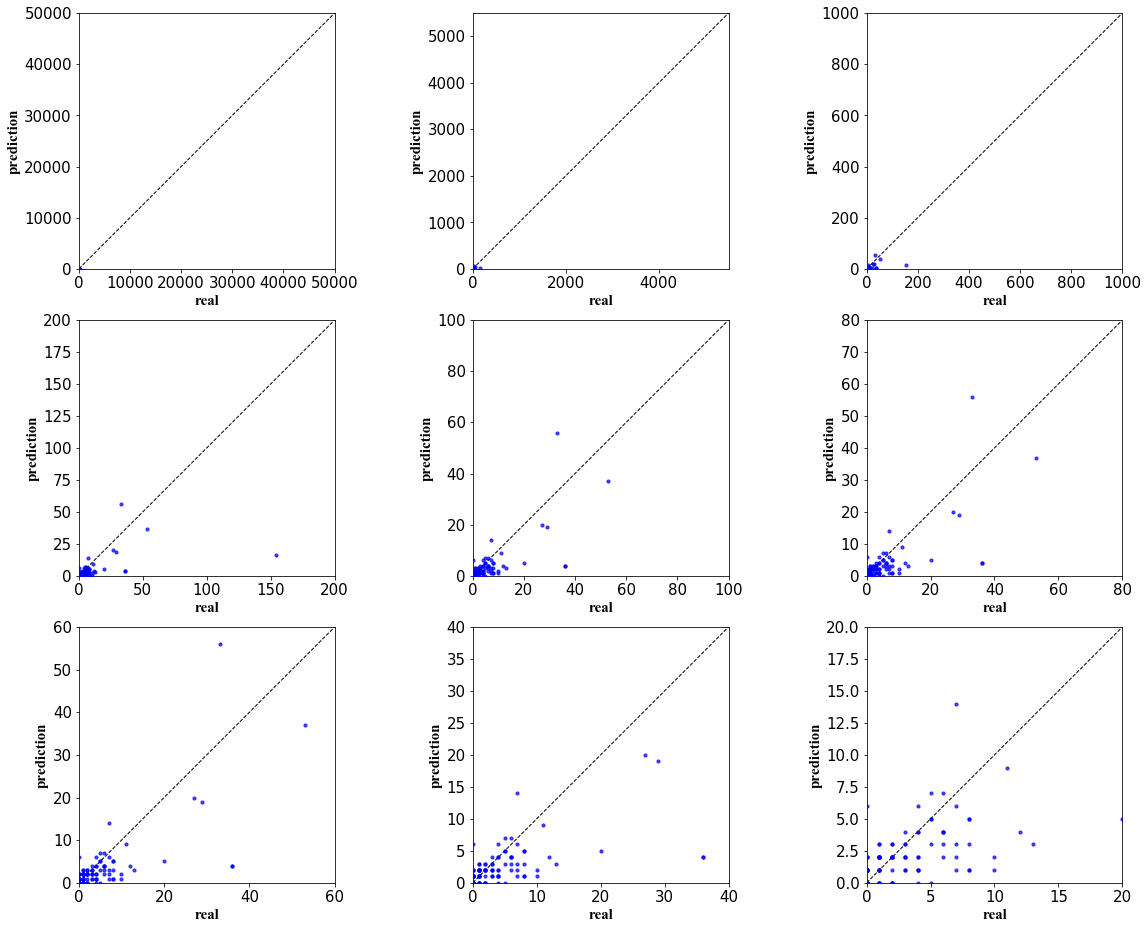

76.0
train fold 2
预测误差较大城市，绝对值误差阈值设置为20
武汉市   real: 698   pre:1275.0
黄石市   real: 36   pre:4.0
宜昌市   real: 31   pre:4.0
襄阳市   real: 36   pre:4.0
黄冈市   real: 154   pre:16.0
随州市   real: 52   pre:3.0
R-squared 0.9429748828219969
R 0.9710689382438288
mae 5.593360995850622
rmse 38.672365679124376


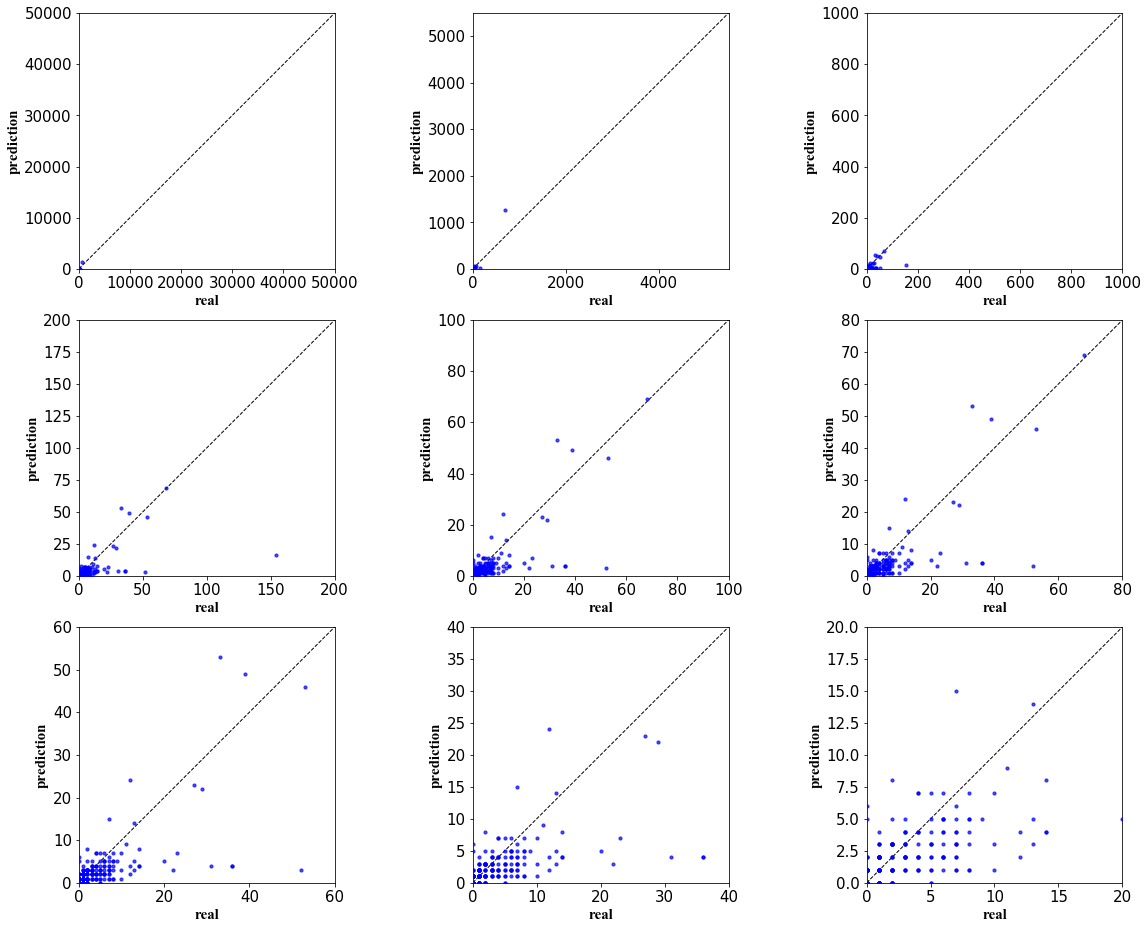

#########################################
test fold 2
预测误差较大城市，绝对值误差阈值设置为20
温州市   real: 32   pre:4.0
十堰市   real: 40   pre:2.0
荆门市   real: 90   pre:2.0
孝感市   real: 100   pre:10.0
荆州市   real: 47   pre:7.0
咸宁市   real: 64   pre:5.0
恩施土家族苗族自治州   real: 25   pre:3.0
重庆市   real: 110   pre:62.0
R-squared 0.41063153884465275
R 0.6408053829710334
mae 5.058333333333334
rmse 15.024147230375506


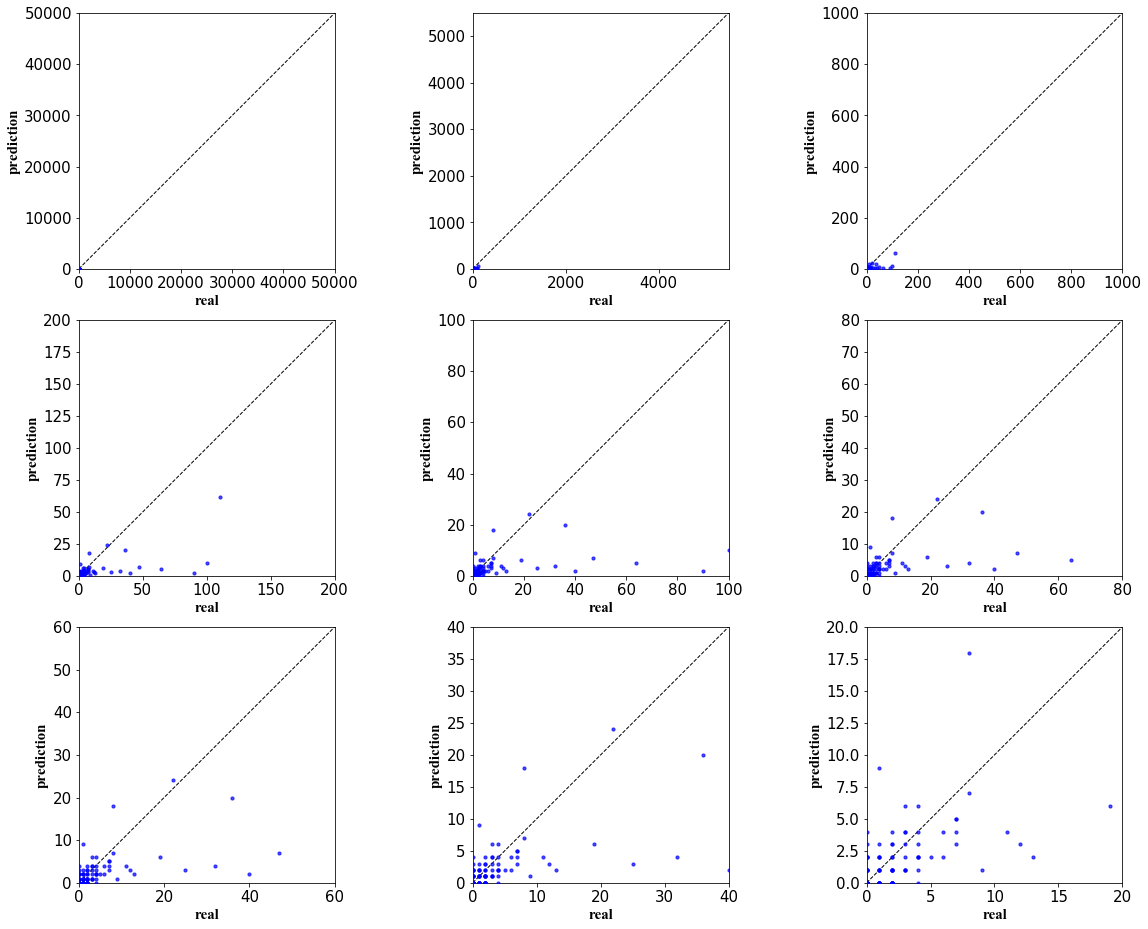

113.0
train fold 3
预测误差较大城市，绝对值误差阈值设置为20
温州市   real: 32   pre:3.0
黄石市   real: 36   pre:12.0
十堰市   real: 40   pre:4.0
襄阳市   real: 36   pre:13.0
荆门市   real: 90   pre:7.0
孝感市   real: 100   pre:444.0
黄冈市   real: 154   pre:447.0
咸宁市   real: 64   pre:22.0
重庆市   real: 110   pre:54.0
成都市   real: 33   pre:61.0
R-squared 0.5661783095314135
R 0.7524482105310727
mae 5.75103734439834
rmse 30.381529658632072


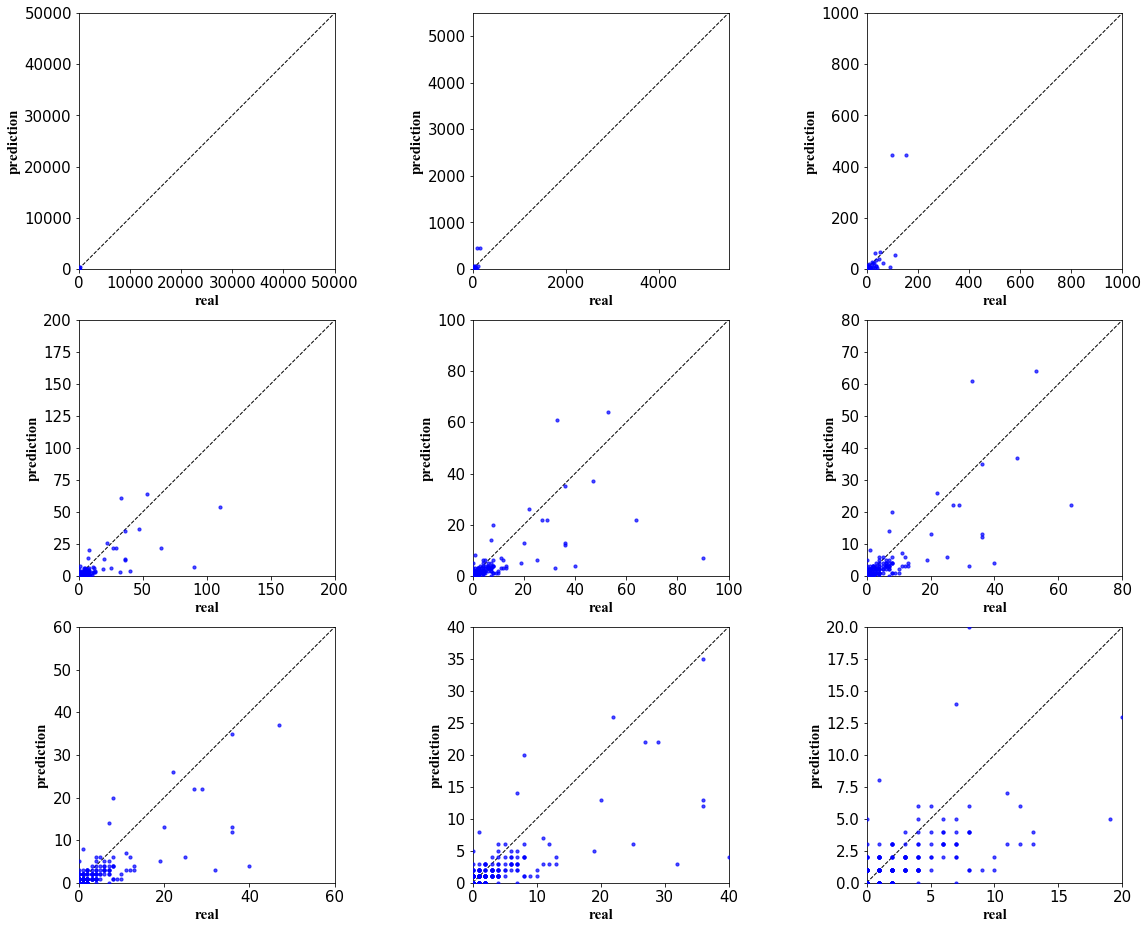

#########################################
test fold 3
预测误差较大城市，绝对值误差阈值设置为20
北京市   real: 68   pre:94.0
武汉市   real: 698   pre:1.1776680723376992e+16
宜昌市   real: 31   pre:8.0
随州市   real: 52   pre:6.0
广州市   real: 39   pre:69.0
R-squared 0.9784187853449751
R 0.9891505372515222
mae 98139006028138.94
rmse 1075058947454908.9


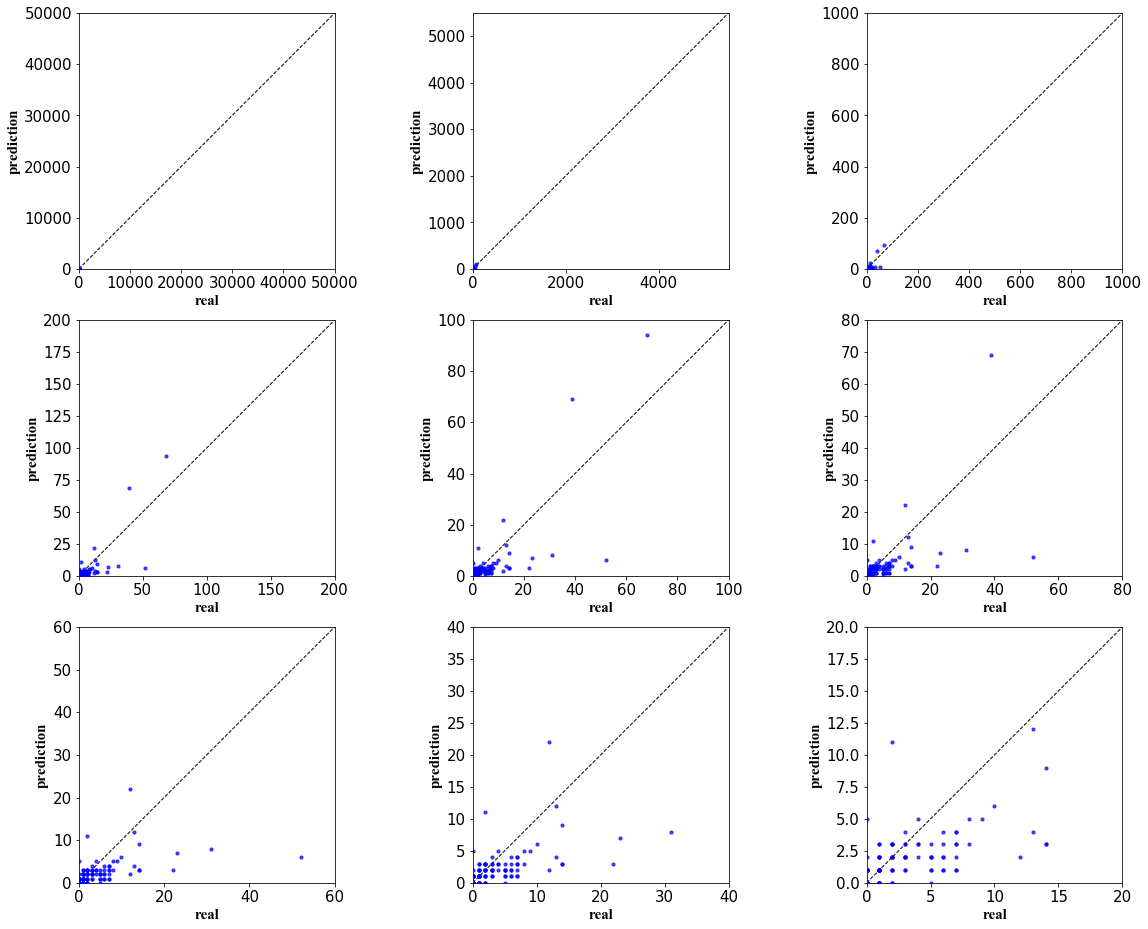

************* cv evaluation ***************
R-squared 0.8587488302252623
R 0.926687018483189
mae 32622384275284.586
rmse 619825301230331.2


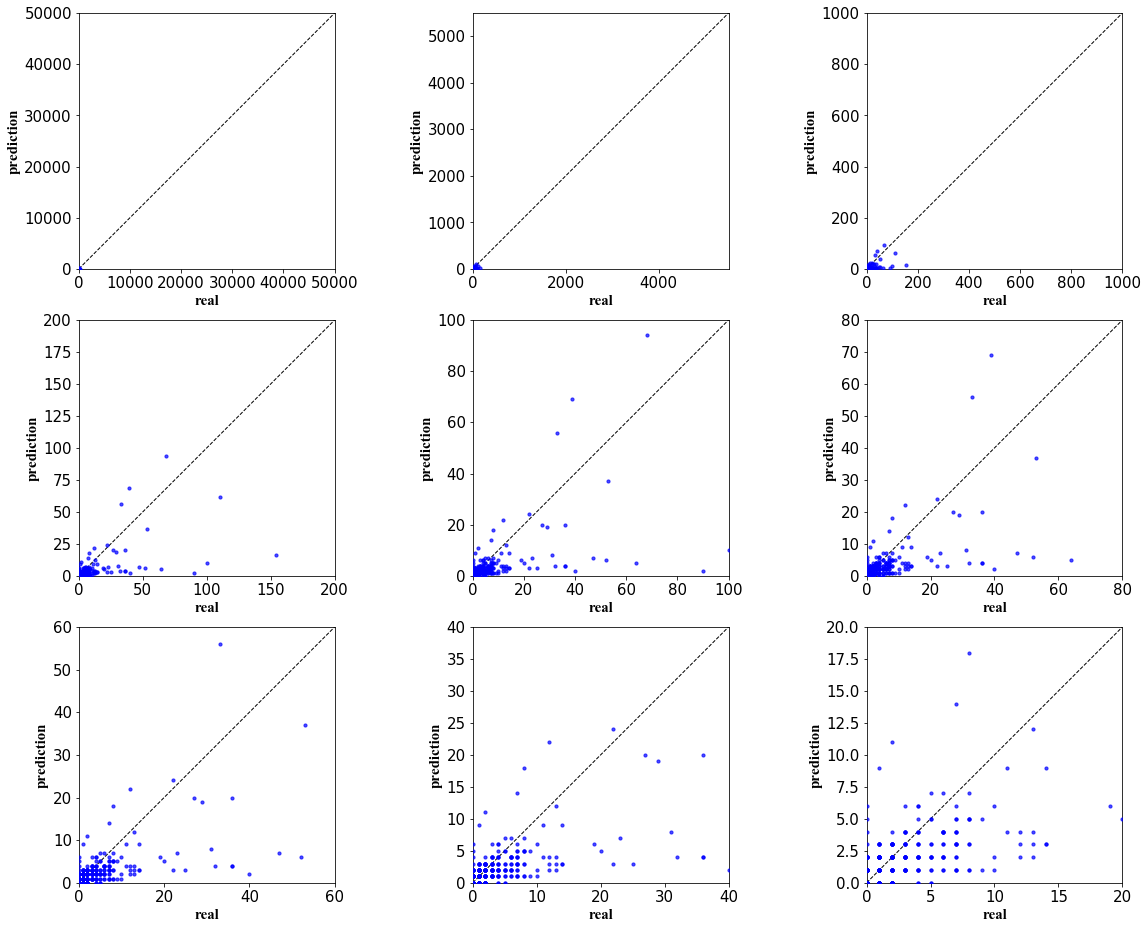

In [302]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_before.shp")  
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id 疫情灾区id，暂定武汉
epidemicIds = [420100]

# 全时间段建模
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 20)

In [303]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [ ]:
# 预测过低城市

# 大多是湖北城市，其他预测过低判断是WuhanMean较低引起的？比如温州，恩施，重庆

In [304]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
176,421100,黄冈市,154,16.0,82.857096,277.756878,2.274531,1.006516,4.852458,12.606538,138.0
174,420900,孝感市,100,10.0,80.659195,277.136510,1.596307,0.961099,4.722062,13.395769,90.0
173,420800,荆门市,90,2.0,79.101923,277.325860,0.786025,0.501414,5.055546,3.047308,88.0
177,421200,咸宁市,64,5.0,86.336734,278.122550,0.928249,0.532652,5.350531,5.103462,59.0
251,500000,重庆市,110,62.0,81.690700,279.615017,6.699337,5.046055,5.064838,1.210385,48.0
178,421300,随州市,52,6.0,79.398717,276.382933,0.649905,0.343983,4.675454,2.953077,46.0
175,421000,荆州市,47,7.0,80.572126,278.208717,1.829269,1.006547,4.807362,6.083077,40.0
169,420300,十堰市,40,2.0,81.701616,274.962732,0.697258,0.462346,4.985946,1.868462,38.0
168,420200,黄石市,36,4.0,84.723337,278.568547,0.920516,0.682005,5.070831,3.765000,32.0
171,420600,襄阳市,36,4.0,79.570638,276.204545,1.297927,0.795673,5.157888,3.812692,32.0


In [ ]:
# 预测过高城市

# 调了很久，武汉预测的非常离谱，数值始终下不来，非常大；其他地区基本高估超过一倍

In [305]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
167,420100,武汉市,698,1.177668e+16,82.161216,277.927893,3.691429,6.322494,4.120335,100.000000,-1.177668e+16
198,440100,广州市,39,6.900000e+01,71.248583,290.618403,7.572659,14.140525,3.804012,0.671154,-3.000000e+01
0,110000,北京市,68,9.400000e+01,46.952353,267.598395,8.432141,13.719755,5.149477,1.179615,-2.600000e+01
252,510100,成都市,33,5.600000e+01,80.743644,277.973750,6.869302,11.031725,4.805092,0.526154,-2.300000e+01


In [455]:
# 管控后疫情建模分析

110.0
train fold 1
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 512   pre:271.0
天津市   real: 160   pre:43.0
哈尔滨市   real: 190   pre:17.0
上海市   real: 463   pre:175.0
杭州市   real: 154   pre:305.0
宁波市   real: 144   pre:28.0
温州市   real: 472   pre:288.0
台州市   real: 124   pre:49.0
合肥市   real: 161   pre:278.0
安庆市   real: 75   pre:17.0
亳州市   real: 102   pre:14.0
郑州市   real: 128   pre:183.0
信阳市   real: 251   pre:154.0
周口市   real: 65   pre:158.0
武汉市   real: 49308   pre:124431.0
黄石市   real: 979   pre:380.0
十堰市   real: 632   pre:225.0
宜昌市   real: 900   pre:205.0
鄂州市   real: 1374   pre:1513.0
荆门市   real: 838   pre:294.0
孝感市   real: 3418   pre:652.0
黄冈市   real: 2753   pre:416.0
咸宁市   real: 772   pre:182.0
随州市   real: 1255   pre:332.0
恩施土家族苗族自治州   real: 227   pre:30.0
仙桃市   real: 563   pre:391.0
潜江市   real: 193   pre:440.0
邵阳市   real: 94   pre:22.0
珠海市   real: 91   pre:24.0
惠州市   real: 54   pre:135.0
重庆市   real: 469   pre:1123.0
甘孜藏族自治州   real: 76   pre:3.0
咸阳市   real: 13   pre:78.0
R-squared 0.9913916459142094
R 

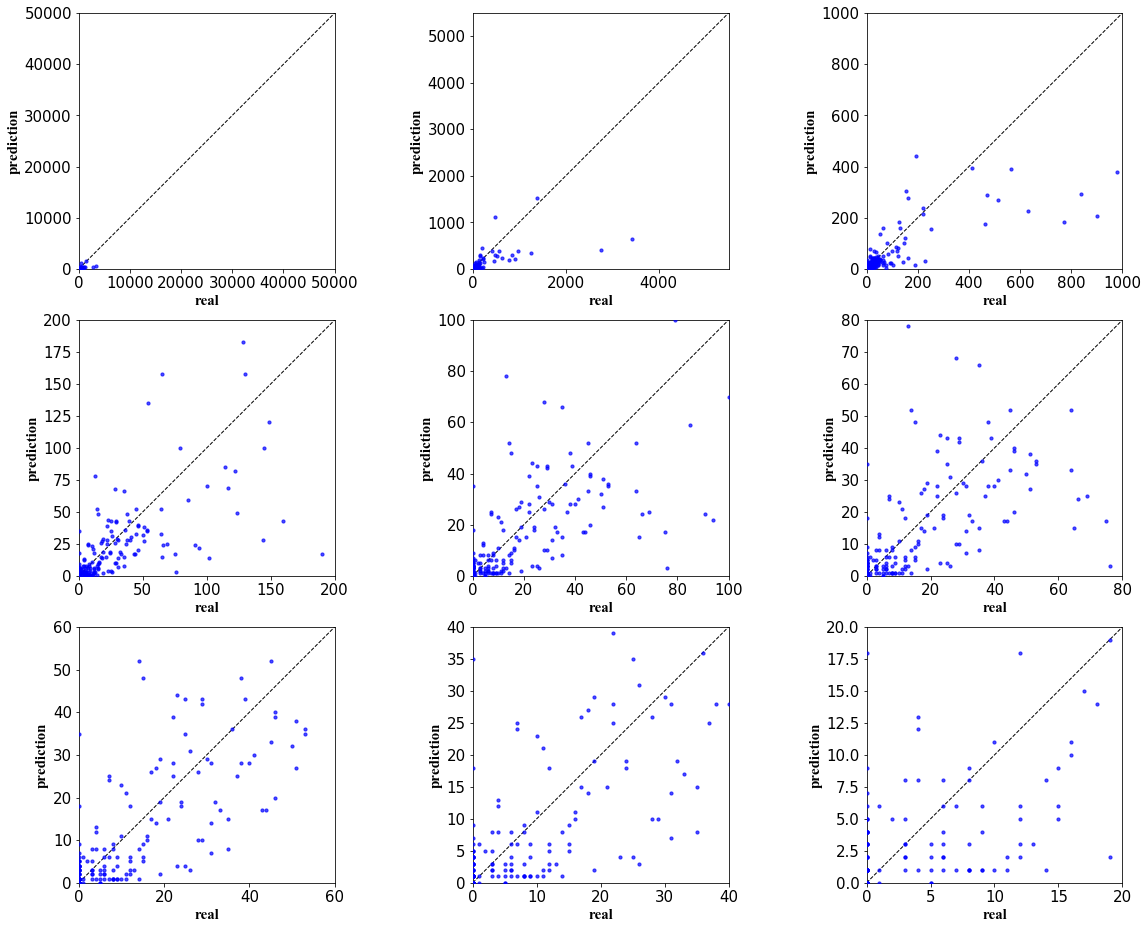

#########################################
test fold 1
预测误差较大城市，绝对值误差阈值设置为50
蚌埠市   real: 157   pre:48.0
新余市   real: 127   pre:60.0
济宁市   real: 255   pre:50.0
襄阳市   real: 1139   pre:346.0
荆州市   real: 1533   pre:445.0
天门市   real: 483   pre:106.0
广州市   real: 396   pre:768.0
佛山市   real: 79   pre:143.0
东莞市   real: 98   pre:436.0
西安市   real: 108   pre:179.0
R-squared 0.4381695353836792
R 0.661943755453346
mae 39.553719008264466
rmse 138.09267459521342


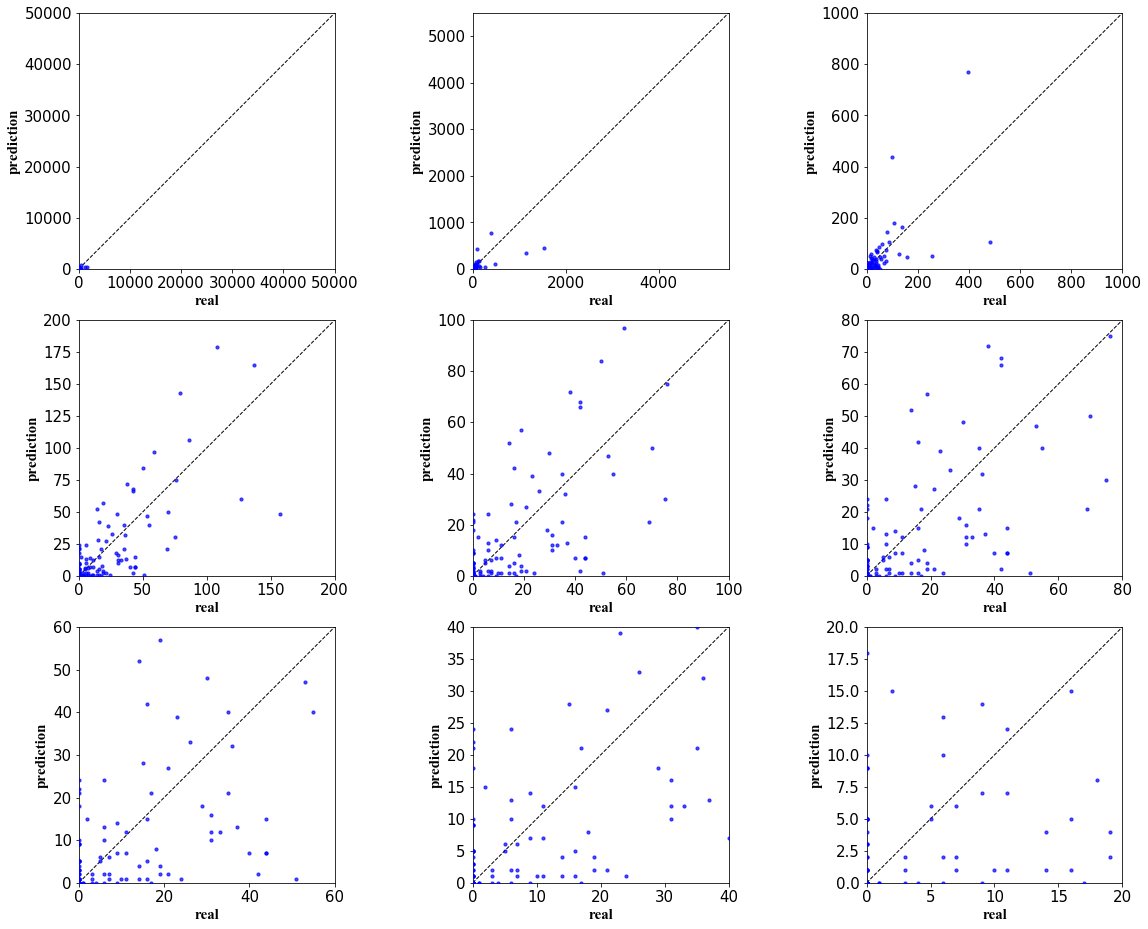

81.0
train fold 2
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 160   pre:58.0
温州市   real: 472   pre:170.0
合肥市   real: 161   pre:214.0
蚌埠市   real: 157   pre:46.0
安庆市   real: 75   pre:22.0
新余市   real: 127   pre:67.0
济宁市   real: 255   pre:52.0
信阳市   real: 251   pre:176.0
周口市   real: 65   pre:181.0
武汉市   real: 49308   pre:63732.0
宜昌市   real: 900   pre:257.0
襄阳市   real: 1139   pre:427.0
荆门市   real: 838   pre:462.0
荆州市   real: 1533   pre:638.0
咸宁市   real: 772   pre:285.0
随州市   real: 1255   pre:452.0
恩施土家族苗族自治州   real: 227   pre:30.0
天门市   real: 483   pre:168.0
广州市   real: 396   pre:310.0
R-squared 0.9984333845258315
R 0.9992163852368673
mae 91.66804979253112
rmse 936.0721458523717


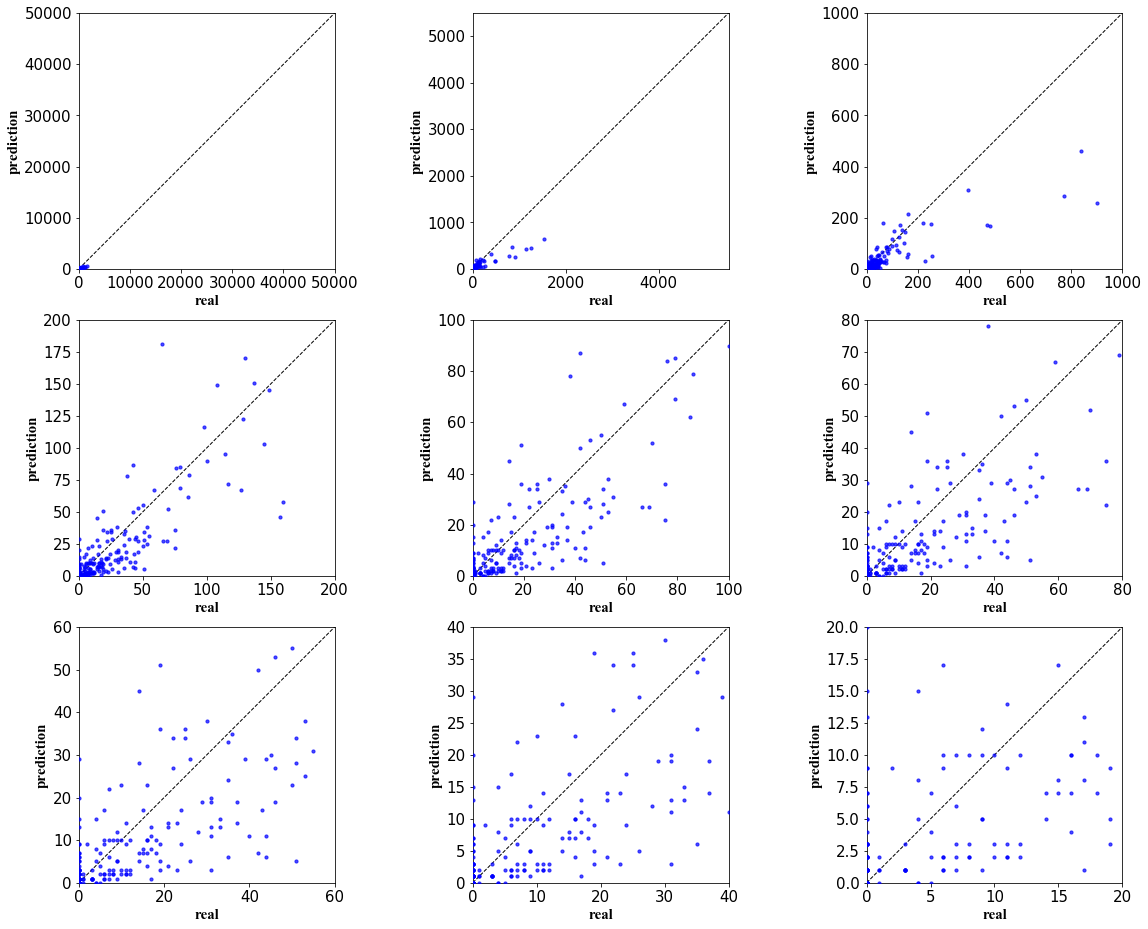

#########################################
test fold 2
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 512   pre:410.0
哈尔滨市   real: 190   pre:30.0
上海市   real: 463   pre:96.0
宁波市   real: 144   pre:19.0
台州市   real: 124   pre:36.0
亳州市   real: 102   pre:13.0
黄石市   real: 979   pre:579.0
十堰市   real: 632   pre:218.0
鄂州市   real: 1374   pre:2435.0
孝感市   real: 3418   pre:780.0
黄冈市   real: 2753   pre:423.0
仙桃市   real: 563   pre:724.0
潜江市   real: 193   pre:866.0
邵阳市   real: 94   pre:25.0
深圳市   real: 414   pre:114.0
珠海市   real: 91   pre:12.0
重庆市   real: 469   pre:309.0
成都市   real: 122   pre:410.0
甘孜藏族自治州   real: 76   pre:0.0
R-squared 0.3477521756032912
R 0.5897051598920355
mae 86.24166666666666
rmse 350.6856023087727


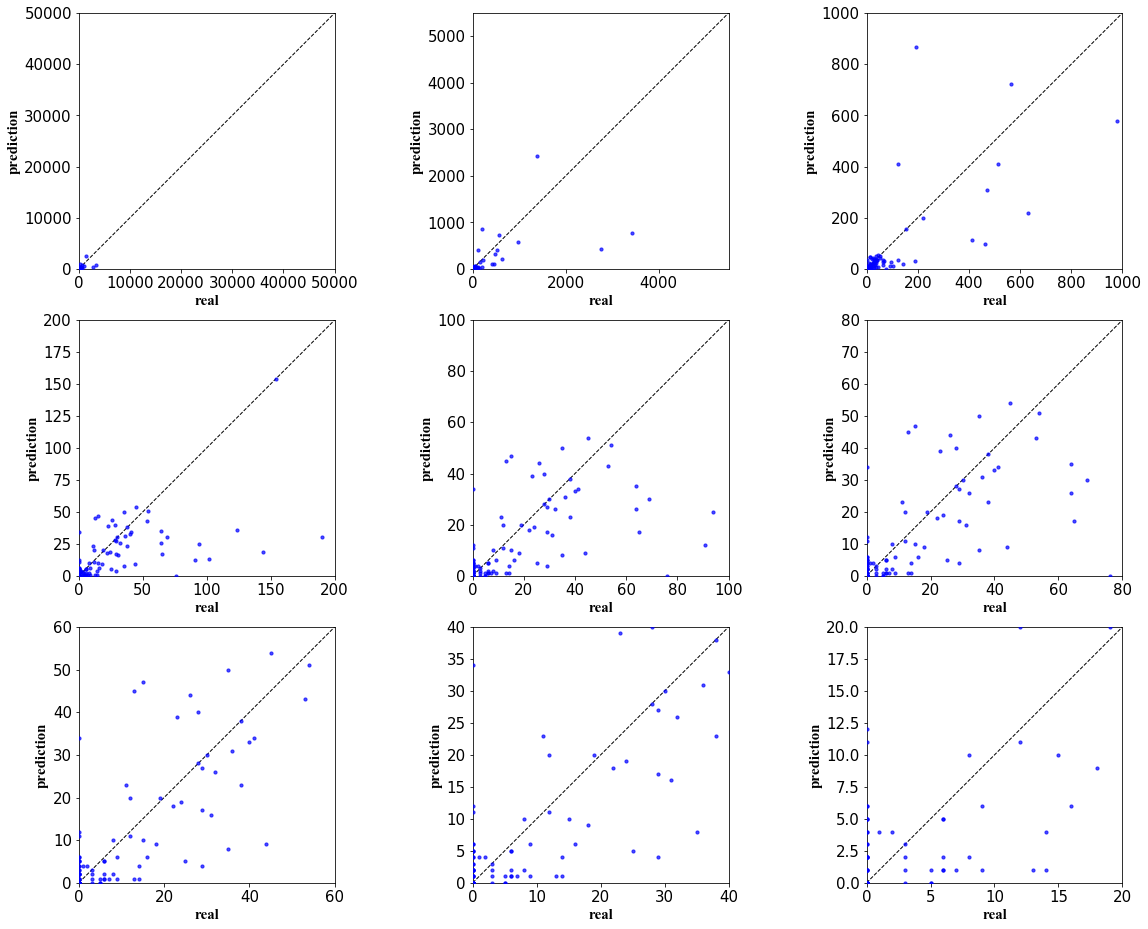

86.0
train fold 3
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 512   pre:320.0
哈尔滨市   real: 190   pre:74.0
上海市   real: 463   pre:302.0
杭州市   real: 154   pre:310.0
宁波市   real: 144   pre:37.0
台州市   real: 124   pre:45.0
蚌埠市   real: 157   pre:39.0
亳州市   real: 102   pre:19.0
新余市   real: 127   pre:52.0
抚州市   real: 65   pre:14.0
济宁市   real: 255   pre:44.0
黄石市   real: 979   pre:469.0
十堰市   real: 632   pre:281.0
襄阳市   real: 1139   pre:401.0
鄂州市   real: 1374   pre:2159.0
孝感市   real: 3418   pre:3619.0
荆州市   real: 1533   pre:744.0
黄冈市   real: 2753   pre:4594.0
仙桃市   real: 563   pre:422.0
潜江市   real: 193   pre:345.0
天门市   real: 483   pre:101.0
邵阳市   real: 94   pre:27.0
广州市   real: 396   pre:655.0
深圳市   real: 414   pre:183.0
珠海市   real: 91   pre:15.0
甘孜藏族自治州   real: 76   pre:1.0
R-squared 0.8585583628023925
R 0.9265842448490005
mae 40.42323651452282
rmse 159.75549263604645


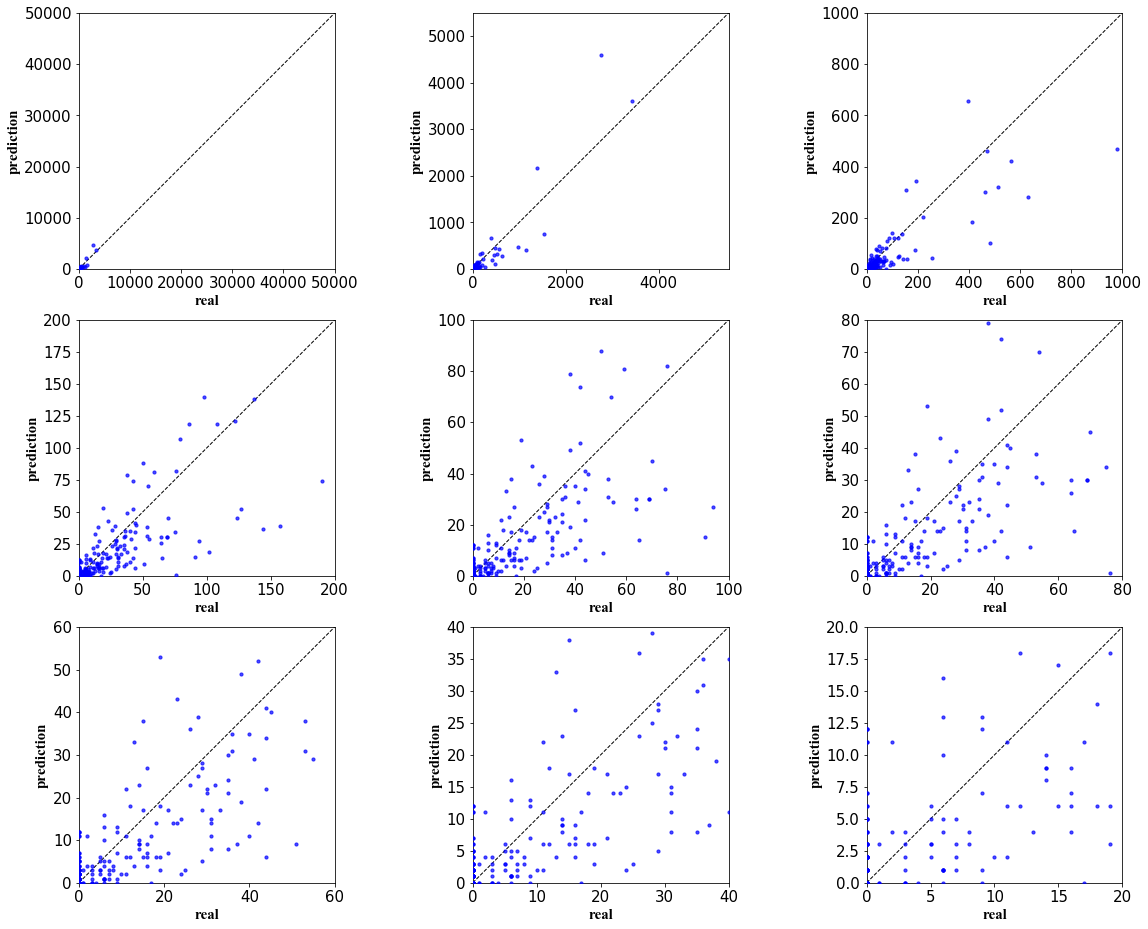

#########################################
test fold 3
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 160   pre:37.0
苏州市   real: 79   pre:166.0
温州市   real: 472   pre:251.0
合肥市   real: 161   pre:279.0
安庆市   real: 75   pre:18.0
上饶市   real: 117   pre:49.0
信阳市   real: 251   pre:169.0
周口市   real: 65   pre:233.0
武汉市   real: 49308   pre:16993227861.0
宜昌市   real: 900   pre:375.0
荆门市   real: 838   pre:286.0
咸宁市   real: 772   pre:348.0
随州市   real: 1255   pre:287.0
恩施土家族苗族自治州   real: 227   pre:75.0
长沙市   real: 220   pre:351.0
R-squared 0.9984231176877144
R 0.999211247778824
mae 141609860.48333332
rmse 1551257869.5318549


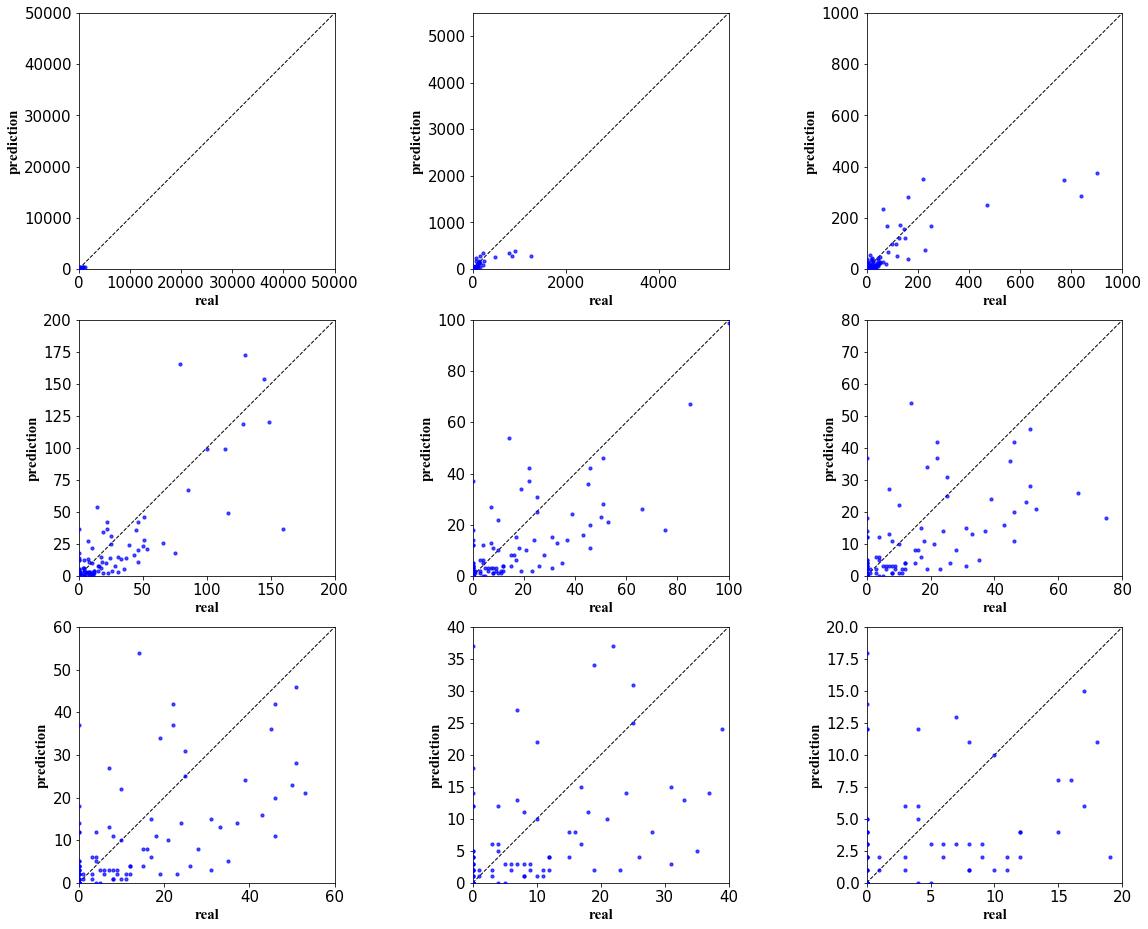

************* cv evaluation ***************
R-squared 0.9876240488518646
R 0.9937927595086737
mae 47072571.72576177
rmse 894377818.5789768


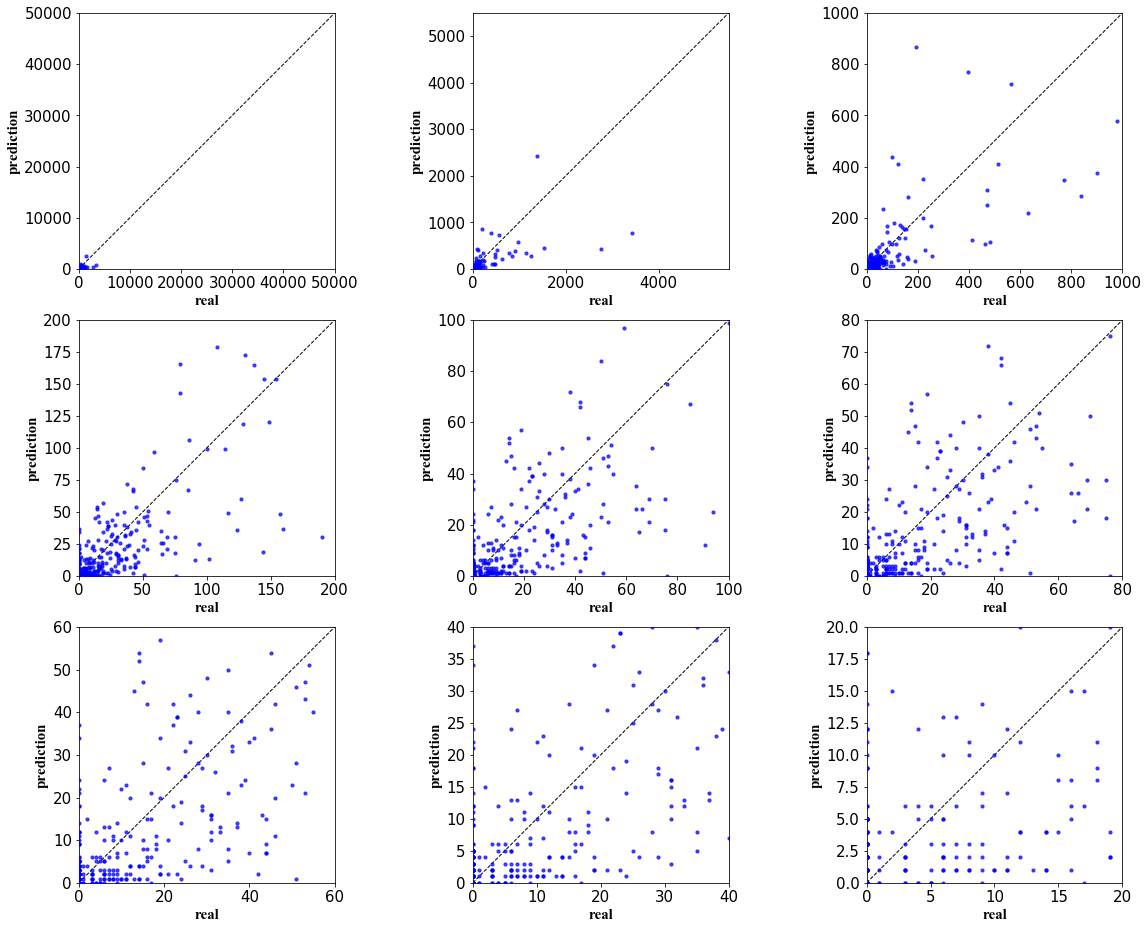

In [462]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_after.shp")
    
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# 全时间段建模
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold=50)

In [463]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [464]:
# 预测过低城市
# 湖北很多预测过低
# 其他城市有些WuhanMean较低，预测的有些少

In [465]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
174,420900,孝感市,3418,780.0,67.495974,283.472206,0.175240,0.276545,2.293580,16.315077,2638.0
176,421100,黄冈市,2753,423.0,70.135725,283.436388,0.190124,0.413585,2.800152,20.989077,2330.0
175,421000,荆州市,1533,445.0,69.231072,284.337159,0.237780,0.419148,2.643878,6.812923,1088.0
178,421300,随州市,1255,287.0,67.635691,282.872199,0.073377,0.132341,2.224703,1.853538,968.0
171,420600,襄阳市,1139,346.0,67.982955,282.419131,0.180650,0.282184,2.327737,3.511538,793.0
173,420800,荆门市,838,286.0,68.712132,283.658828,0.135896,0.191163,2.469442,2.620308,552.0
170,420500,宜昌市,900,375.0,74.232422,281.635819,0.186240,0.215876,2.396275,5.157385,525.0
177,421200,咸宁市,772,348.0,72.217376,284.324717,0.090449,0.161344,2.666323,6.876923,424.0
169,420300,十堰市,632,218.0,68.054072,280.907809,0.106596,0.157351,2.241015,3.627385,414.0
168,420200,黄石市,979,579.0,71.633199,284.422040,0.121287,0.163943,2.207482,2.964462,400.0


In [ ]:
# 预测过高城市

# 调了很久，武汉预测的非常离谱，数值始终下不来，非常大；其他地区基本高估超过一倍

In [466]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
167,420100,武汉市,49308,1.699323e+10,67.548395,284.256138,0.542080,0.303700,0.764031,100.000000,-1.699318e+10
172,420700,鄂州市,1374,2.435000e+03,68.977774,284.789154,0.080072,0.096943,1.504028,5.203231,-1.061000e+03
181,429005,潜江市,193,8.660000e+02,68.510573,284.159537,0.066477,0.086867,2.197575,1.019077,-6.730000e+02
198,440100,广州市,396,7.680000e+02,75.535987,291.145081,5.164597,3.251599,2.391931,0.291846,-3.720000e+02
214,441900,东莞市,98,4.360000e+02,73.799657,292.110542,4.424677,2.442916,2.284398,0.179231,-3.380000e+02
252,510100,成都市,122,4.100000e+02,74.166479,282.088037,3.941828,2.722302,3.120940,0.178308,-2.880000e+02
164,411600,周口市,65,2.330000e+02,58.645659,282.602752,0.711853,1.420206,3.892882,0.066923,-1.680000e+02
180,429004,仙桃市,563,7.240000e+02,68.048552,284.140160,0.079986,0.113498,2.243594,3.041692,-1.610000e+02
184,430100,长沙市,220,3.510000e+02,75.230205,284.888353,2.528474,1.823747,2.973386,0.542615,-1.310000e+02
97,340100,合肥市,161,2.790000e+02,65.723726,283.157851,1.597716,1.286218,3.076028,0.263385,-1.180000e+02


In [467]:
# 总结

# GWR的训练过程非常不稳定，预测值有时候非常大，除了武汉，个别其他城市也会出现

# cv-r2非常高，高的离谱，应该是python里把武汉去掉计算了